# Sentiment Analysis

Please note that most of the code is inspired by this Youtube video: https://www.youtube.com/watch?v=QpzMWQvxXWk

In [28]:
#Libaries and packages
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

#Implement the style for plots
plt.style.use("ggplot")

# Import seaborn for visualizatons: https://seaborn.pydata.org/tutorial/introduction.html
import seaborn as sns
sns.set_theme() #Set the default theme

import nltk
nltk.download('averaged_perceptron_tagger')
#nltk.downloader.download('vader_lexicon') # Download Vader Lexicon



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kristofferkristensen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kristofferkristensen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Import data

In [29]:

#Import data_preprocessed containing TripAdvisor reviews preprocessed
df = pd.read_csv("../Trip Advisor Preprocessing/data_preprocessed.csv")

# add a new column with unique IDs starting from 1
df.insert(0, 'id', range(1, 1+len(df)))

df = df[['id','text', 'ratings.overall']]
df

,id,text,ratings.overall
0,1,rooms are fine service tries hard but does not...,3.0
1,2,best place to stay in nyc want to go back miss...,5.0
2,3,pleasant very pleasant clean room nice bathroo...,4.0
3,4,good family hotel in a good neighborhood hotel...,3.0
4,5,we had a beautiful deluxe room with amazing vi...,5.0
...,...,...,...
23476,23477,close to the capitol and to the museum of art ...,5.0
23477,23478,overall friendly feel employees want to be the...,5.0
23478,23479,clean and quiet rooms wifi was easy to setup b...,5.0
23479,23480,great new embassy suites service staff excelle...,5.0


In [30]:
# Display a example value of a review
example = df["text"].values[5]
example

'great location delis everywhere great for families 2 thumbs up'

In [31]:
#Tokenize the example
tokens = nltk.word_tokenize(example)
tokens[:25]

['great',
 'location',
 'delis',
 'everywhere',
 'great',
 'for',
 'families',
 '2',
 'thumbs',
 'up']

# Sentiment Analysis with roBERTa

In [32]:
# Pull in a specific and pre-trained model 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [33]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt")
    output = model(**encoded_text) 
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)): #Total lenght of the dataframe
    text = row["text"]
    myid = row["id"]
    res[myid] = polarity_scores_roberta(text)       

  0%|          | 0/23481 [00:00<?, ?it/s]

In [35]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={"index": "id"})
results_df = results_df.merge(df, how="left")
results_df.head()

results_df.columns

Index(['id', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'text',
       'ratings.overall'],
      dtype='object')

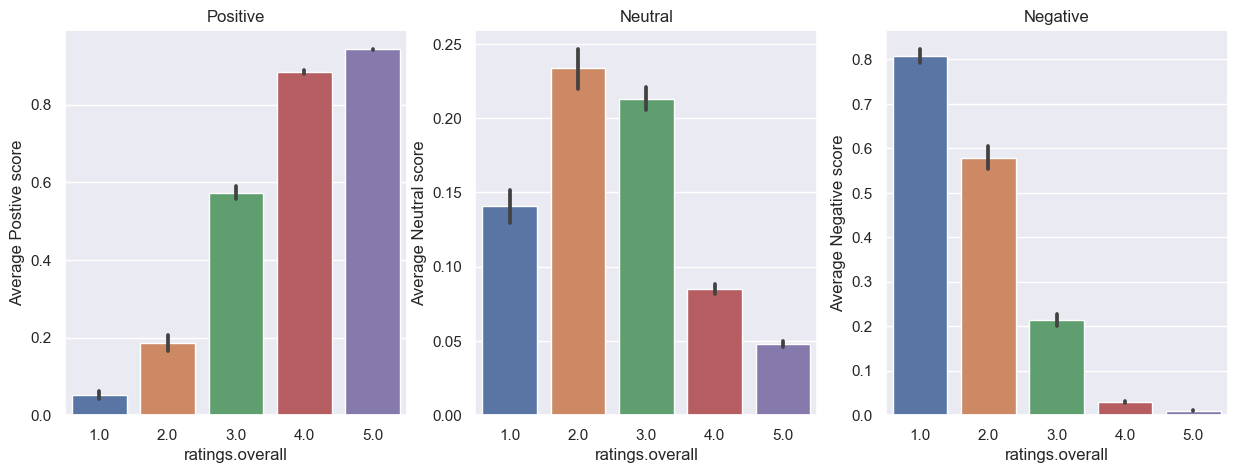

In [41]:
# Plot the three figures: Positive, neutral and negative...
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=results_df, x="ratings.overall", y="roberta_pos",ax=axs[0])
sns.barplot(data=results_df, x="ratings.overall", y="roberta_neu",ax=axs[1])
sns.barplot(data=results_df, x="ratings.overall", y="roberta_neg",ax=axs[2])
axs[0].set_title("Positive")
axs[0].set_ylabel("Average Postive score")
axs[1].set_title("Neutral")
axs[1].set_ylabel("Average Neutral score")
axs[2].set_title("Negative")
axs[2].set_ylabel("Average Negative score")
plt.show()

In [37]:
results_df.head(5)

,id,roberta_neg,roberta_neu,roberta_pos,text,ratings.overall
0,1,0.193569,0.504832,0.301599,rooms are fine service tries hard but does not...,3.0
1,2,0.007111,0.056296,0.936593,best place to stay in nyc want to go back miss...,5.0
2,3,0.002138,0.017366,0.980496,pleasant very pleasant clean room nice bathroo...,4.0
3,4,0.003555,0.033515,0.962930,good family hotel in a good neighborhood hotel...,3.0
4,5,0.001355,0.010270,0.988375,we had a beautiful deluxe room with amazing vi...,5.0


Below is some examples of the actual rating beign 1, whereas the roBERTa predicted rating is sorted descedning - and the other way around. This reveals some outliers in the dataset.

In [42]:
results_df.query('`ratings.overall` == 1').sort_values("roberta_pos", ascending=False).values[0]

array([12458, 0.001669062301516533, 0.012643501162528992,
       0.9856874346733093,
       'we had a vonderful stay first time in san antonio our valet robert was so very helpful and went beyond the call of duty to help us',
       1.0], dtype=object)

In [43]:
results_df.query('`ratings.overall` == 5').sort_values("roberta_neg", ascending=False).values[0]

array([11226, 0.9623758792877197, 0.034030795097351074,
       0.0035932199098169804,
       'some one hit my rented 2010 white c300 mercedes about 80000 damage who ever did this i hope they rot in hell',
       5.0], dtype=object)